Fitting 5 folds for each of 108 candidates, totalling 540 fits

=== Best Model Performance ===
Best Parameters: {'feature_selection__k': 25, 'regressor__learning_rate': 0.1, 'regressor__max_depth': 3, 'regressor__n_estimators': 200, 'regressor__subsample': 0.8}
R² Score: 0.9551
MSE: 0.1021
RMSE: 0.3196


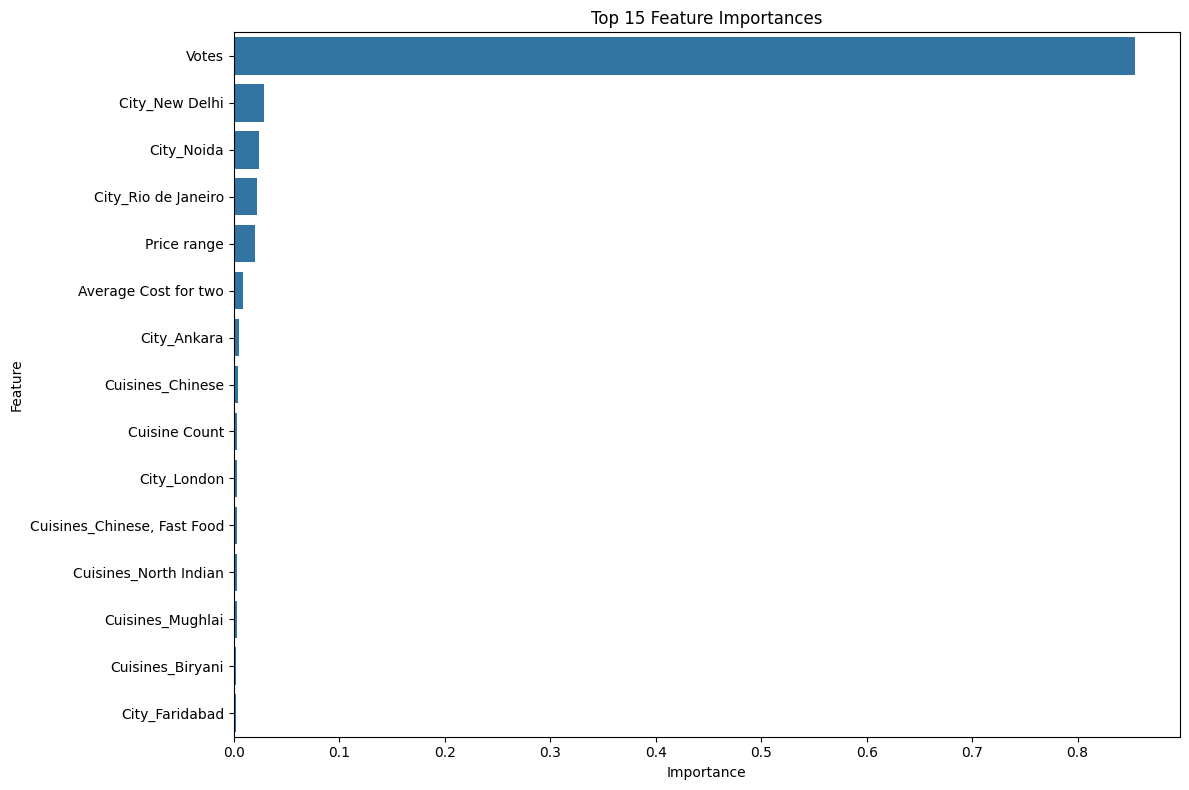


Cross-validated R²: 0.9446 (±0.0187)


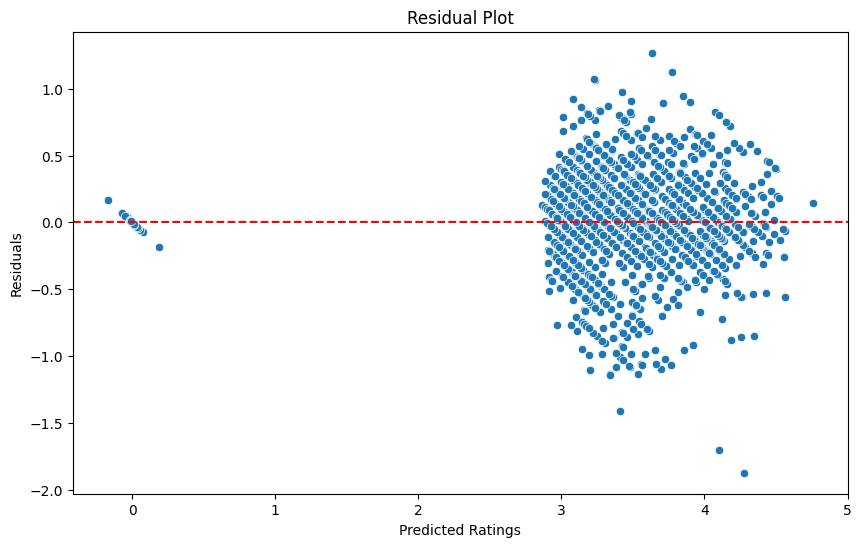

In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
import matplotlib.pyplot as plt
import seaborn as sns

# Load and prepare data
df = pd.read_csv("Dataset .csv")

# Feature engineering
df['Has Online Delivery'] = df['Has Online delivery'].map({'Yes': 1, 'No': 0})
df['Has Table Booking'] = df['Has Table booking'].map({'Yes': 1, 'No': 0})
df['Cuisine Count'] = df['Cuisines'].apply(lambda x: len(str(x).split(',')))
df['Is Tourist City'] = df['City'].isin(['London', 'New York', 'Dubai', 'Paris']).astype(int)

# Select features and target
X = df[['Votes', 'Price range', 'Average Cost for two',
         'Has Online Delivery', 'Has Table Booking',
         'Cuisine Count', 'Is Tourist City', 'City', 'Cuisines']]
y = df['Aggregate rating']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing pipeline
numeric_features = ['Votes', 'Price range', 'Average Cost for two', 'Cuisine Count']
categorical_features = ['City', 'Cuisines']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Model pipeline with feature selection
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selection', SelectKBest(f_regression, k=20)),
    ('regressor', XGBRegressor(random_state=42))
])

# Hyperparameter tuning
params = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [3, 5, 7],
    'regressor__learning_rate': [0.01, 0.1, 0.2],
    'regressor__subsample': [0.8, 1.0],
    'feature_selection__k': [15, 20, 25]
}

# Grid search with cross-validation
grid_search = GridSearchCV(pipeline, params, cv=5, scoring='r2', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Best model evaluation
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("\n=== Best Model Performance ===")
print(f"Best Parameters: {grid_search.best_params_}")
print(f"R² Score: {r2_score(y_test, y_pred):.4f}")
print(f"MSE: {mean_squared_error(y_test, y_pred):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}")

# Feature importance
encoder = best_model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
cat_features = encoder.get_feature_names_out(categorical_features)
all_features = numeric_features + list(cat_features)
selected_indices = best_model.named_steps['feature_selection'].get_support()
selected_features = [f for f, s in zip(all_features, selected_indices) if s]

importances = best_model.named_steps['regressor'].feature_importances_
importance_df = pd.DataFrame({'Feature': selected_features, 'Importance': importances})
importance_df = importance_df.sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(15))
plt.title('Top 15 Feature Importances')
plt.tight_layout()
plt.show()

# Cross-validation score
cv_scores = cross_val_score(best_model, X, y, cv=5, scoring='r2')
print(f"\nCross-validated R²: {np.mean(cv_scores):.4f} (±{np.std(cv_scores):.4f})")

# Residual analysis
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('Predicted Ratings')
plt.ylabel('Residuals')
plt.show()
